In [16]:
!pip install catboost

In [17]:
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, KFold
import pickle
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings("ignore")


In [18]:
df = pd.read_csv("Cleaned_data.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,zipcode,is_location_exact,accommodates,bathrooms,...,host_commitment,bedroom_quality,space_per_guest,seasonal_demand,recent_review_boost,essential_amenities,luxury_amenities,review_consistency,positive_momentum,price_value
0,3881880.0,2,100.0,0,19.0,1,92101.0,1,1.0,1.0,...,1530.333333,0.666667,0.476190,-0.471160,1.0,3,3,0.011628,58.917510,40.000000
1,4888818.0,2,100.0,0,1.0,0,92122.0,1,8.0,2.0,...,166.111111,1.400000,1.568627,0.972118,0.5,2,0,0.132653,255.988561,18.875000
2,9832430.0,2,100.0,1,12.0,0,92103.0,1,3.0,1.0,...,24.590643,0.666667,2.727273,-0.128748,0.5,3,1,0.858586,436.526035,39.666667
3,183755154.0,1,100.0,1,7.0,0,92101.0,1,2.0,1.0,...,12.145540,0.000000,1.818182,0.523416,0.5,3,0,1.070707,457.937226,59.500000
4,8336938.0,1,100.0,1,21.0,1,92109.0,0,6.0,1.0,...,1426.333333,1.333333,1.463415,-0.985948,1.0,3,0,0.009901,69.314718,77.916667


In [19]:
# Different Features than the First one to enhance Model
enhanced_features = ['host_response_rate','host_is_superhost','host_listings_count','accommodates','bathrooms','bedrooms','beds','number_of_reviews','number_of_stays','review_duration_days','host_duration_days','price_value',
'host_response_power','host_commitment','bedroom_quality','space_per_guest', 'essential_amenities','review_consistency','instant_bookable','host_identity_verified','room_type_cleaned', 'cancellation_policy_cleaned']

In [20]:
## Preprocessing using Pipeline

# Categorize the columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
binary_cols = [c for c in num_cols if df[c].nunique() == 2]
cont_cols = [c for c in num_cols if c not in binary_cols]
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", num_cols)
print("Binary columns:", binary_cols)
print("Continuous columns:", cont_cols)
print("Categorical columns:", cat_cols)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, [f for f in enhanced_features if f not in ['room_type_cleaned', 'cancellation_policy_cleaned']]),
    ('cat', categorical_transformer, ['room_type_cleaned', 'cancellation_policy_cleaned'])
])


Numerical columns: ['host_id', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'zipcode', 'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 'instant_bookable', 'has_heating', 'has_carbon_monoxide_detector', 'has_hot_water', 'has_smoke_detector', 'has_iron', 'has_laptop_friendly_workspace', 'has_kitchen', 'has_air_conditioning', 'has_essentials', 'has_hangers', 'has_wifi', 'has_tv', 'has_lock_on_bedroom_door', 'has_gym', 'has_pool', 'has_hot_tub', 'has_free_parking_on_premises', 'has_private_entrance', 'has_elevator', 'description_cleaned', 'neighborhood_overview_cleaned', 'notes_cleaned', 'transit_cleaned', 'access_cleaned', 'interaction_cleaned', 'house_rules_cleaned', 'host_location_cleaned', 'hos

In [21]:
# Gradient Boosting with Early Stopping
gb_enhanced = GradientBoostingRegressor(n_estimators=200,learning_rate=0.05,max_depth=4,min_samples_split=20,subsample=0.7, validation_fraction=0.2,n_iter_no_change=10, random_state=42)

enhanced_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', gb_enhanced)
])

X_enhanced = df[enhanced_features]
y = df['review_scores_rating']

In [22]:
# K-Fold Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(enhanced_pipeline,X_enhanced,y,cv=kf,scoring='r2')
print(f"\nGradient Boosting Cross-Validation R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

enhanced_pipeline.fit(X_train, y_train)

# Evaluation
train_pred = enhanced_pipeline.predict(X_train)
test_pred = enhanced_pipeline.predict(X_test)

print("Gradient Boosting Model Performance:")
print(f"Train R²: {r2_score(y_train, train_pred):.3f}")
print(f"Test R²: {r2_score(y_test, test_pred):.3f}")
print(f"Overfit: {r2_score(y_train, train_pred) - r2_score(y_test, test_pred):.3f}")


Gradient Boosting Cross-Validation R²: 0.689 (±0.014)
Gradient Boosting Model Performance:
Train R²: 0.735
Test R²: 0.691
Overfit: 0.044


In [23]:
fitted_pipelines = {}
results = []

models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42,tree_method='hist',verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42,force_col_wise=True,verbose=-1,),
    "CatBoost": CatBoostRegressor(iterations=1000,learning_rate=0.1,depth=6,random_state=42,verbose=False,allow_writing_files=False),
    "Random Forest": RandomForestRegressor(random_state=42,n_estimators=100, n_jobs=-1)
}

# K-Fold Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    model_pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

    # Cross-validation scores
    cv_train_scores = cross_val_score(model_pipeline, X_enhanced, y, cv=kf, scoring='r2')
    print(f"Cross-Validation Train R²: {cv_train_scores.mean():.3f} (±{cv_train_scores.std():.3f})")

    X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

    model_pipeline.fit(X_train, y_train)

    fitted_pipelines[model_name] = model_pipeline

    # Predictions
    train_pred = model_pipeline.predict(X_train)
    test_pred = model_pipeline.predict(X_test)

    print(f"Final Train R²: {r2_score(y_train, train_pred):.3f}")
    print(f"Final Test R²: {r2_score(y_test, test_pred):.3f}")
    print(f"Overfit: {r2_score(y_train, train_pred) - r2_score(y_test, test_pred):.3f}")

    results.append({'Model': model_name,'Cross-Validation R² Mean': cv_train_scores.mean(),'Cross-Validation R² Std': cv_train_scores.std(),'Train R²': r2_score(y_train, train_pred),'Test R²': r2_score(y_test, test_pred),'Overfit': r2_score(y_train, train_pred) - r2_score(y_test, test_pred)})



Evaluating Linear Regression...
Cross-Validation Train R²: 0.341 (±0.011)
Final Train R²: 0.345
Final Test R²: 0.341
Overfit: 0.005

Evaluating Gradient Boosting...
Cross-Validation Train R²: 0.618 (±0.018)
Final Train R²: 0.636
Final Test R²: 0.622
Overfit: 0.014

Evaluating XGBoost...
Cross-Validation Train R²: 0.878 (±0.006)
Final Train R²: 0.977
Final Test R²: 0.883
Overfit: 0.093

Evaluating LightGBM...
Cross-Validation Train R²: 0.837 (±0.005)
Final Train R²: 0.895
Final Test R²: 0.831
Overfit: 0.064

Evaluating CatBoost...
Cross-Validation Train R²: 0.927 (±0.003)
Final Train R²: 0.973
Final Test R²: 0.930
Overfit: 0.043

Evaluating Random Forest...
Cross-Validation Train R²: 0.715 (±0.014)
Final Train R²: 0.961
Final Test R²: 0.716
Overfit: 0.245


In [25]:
# Convert results to a DataFrame
model_comparison = pd.DataFrame(results)
model_comparison.sort_values(by='Test R²', ascending=False, inplace=True)

# Display the model comparison table
print("\nModel Comparison:")
print(model_comparison)


Model Comparison:
               Model  Cross-Validation R² Mean  Cross-Validation R² Std  \
4           CatBoost                  0.927428                 0.002542   
2            XGBoost                  0.877836                 0.005780   
3           LightGBM                  0.837046                 0.005415   
5      Random Forest                  0.715423                 0.013596   
1  Gradient Boosting                  0.618039                 0.017709   
0  Linear Regression                  0.340613                 0.011328   

   Train R²   Test R²   Overfit  
4  0.972897  0.929551  0.043346  
2  0.976713  0.883236  0.093477  
3  0.895113  0.831474  0.063639  
5  0.960559  0.715544  0.245016  
1  0.635917  0.621804  0.014114  
0  0.345324  0.340543  0.004781  


In [26]:
best = max(results, key=lambda x: x['Test R²'])
best_name = best['Model']
best_pipe = fitted_pipelines[best_name]

filename = best_name.replace(' ', '_') + '.pkl'
with open(filename, 'wb') as f:
    pickle.dump(best_pipe, f)

print(f"Saved {best_name} pipeline to {filename}")

Saved CatBoost pipeline to CatBoost.pkl


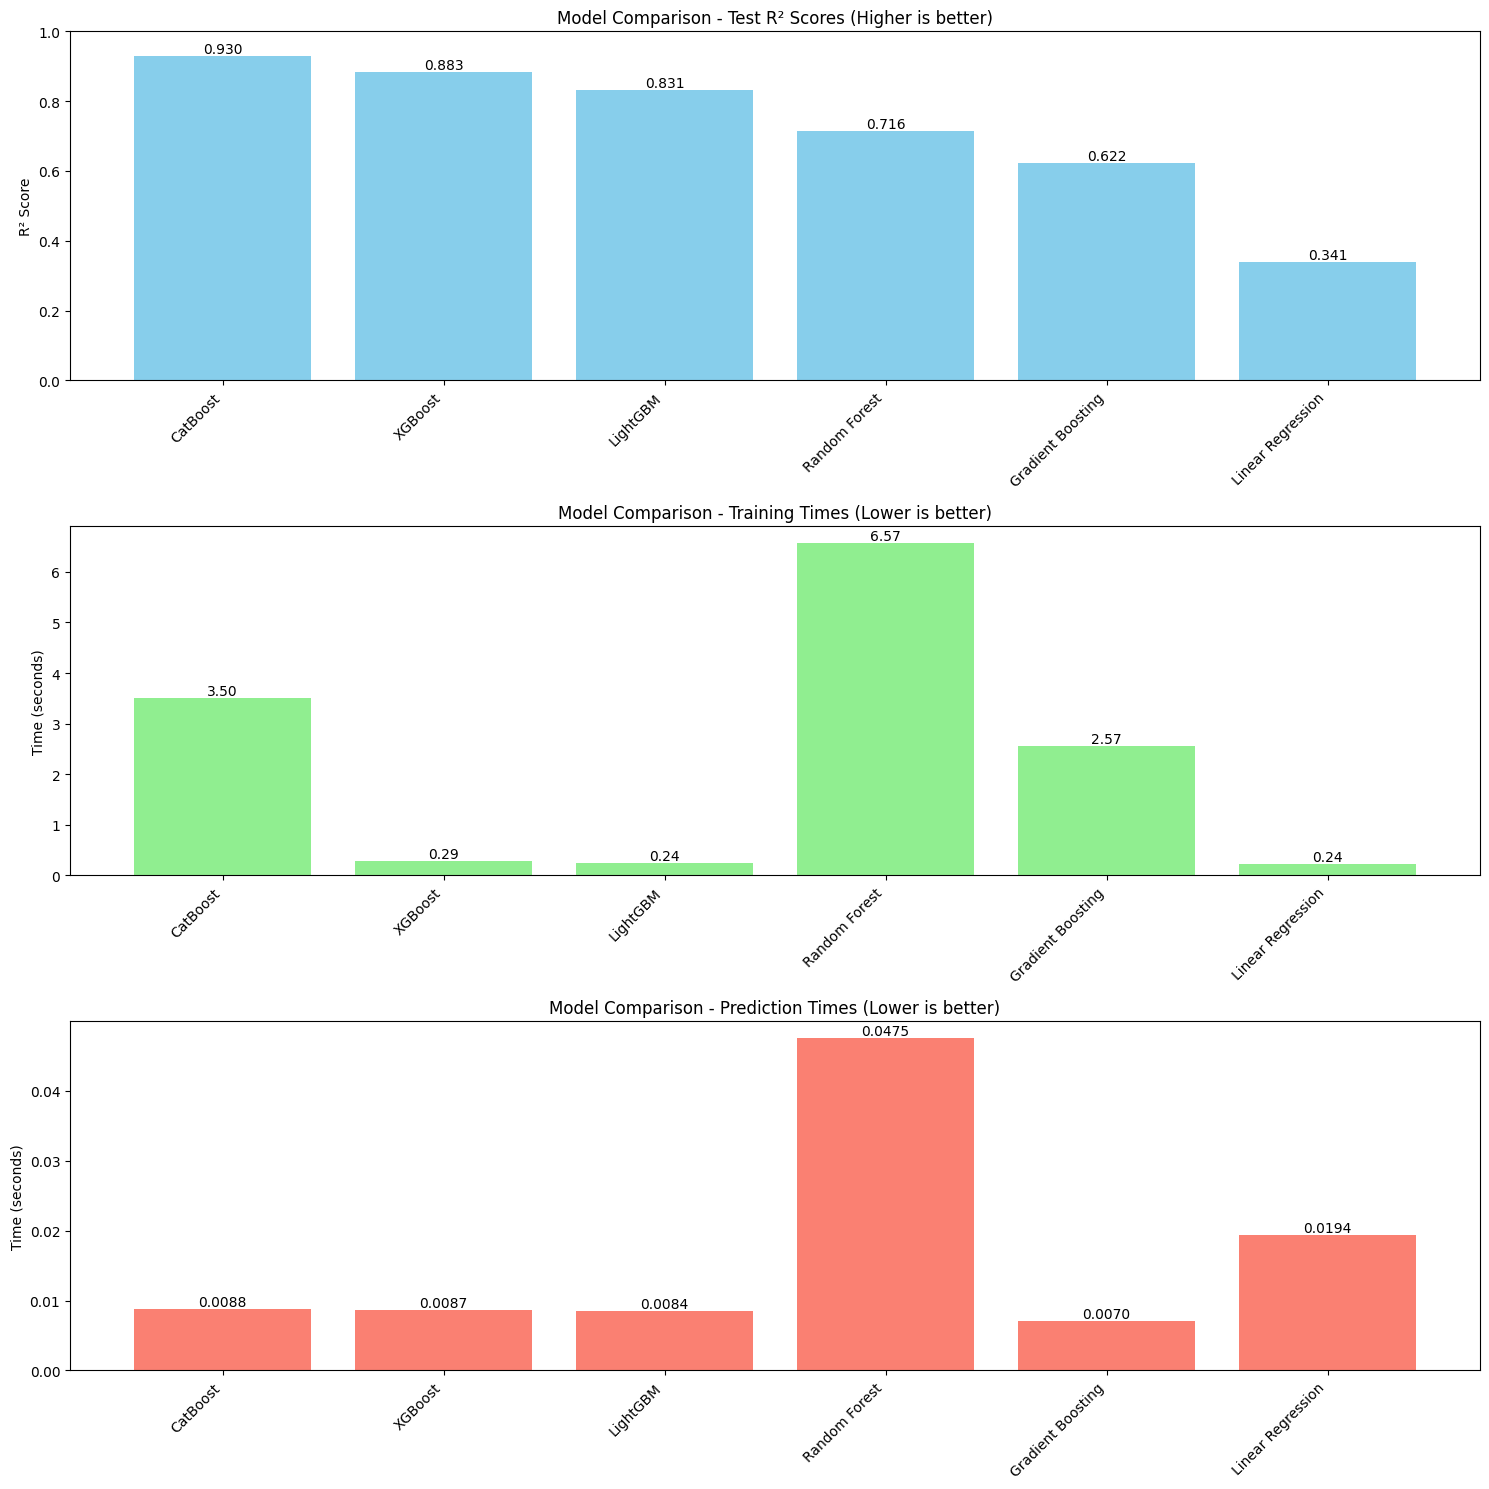


Complete Model Comparison:


,Model,Cross-Validation R² Mean,Cross-Validation R² Std,Train R²,Test R²,Overfit,Train Time (s),Test Time (s)
0,CatBoost,0.927428,0.002542,0.972897,0.929551,0.043346,3.504510,0.008815
1,XGBoost,0.877836,0.005780,0.976713,0.883236,0.093477,0.285460,0.008700
2,LightGBM,0.837046,0.005415,0.895113,0.831474,0.063639,0.243922,0.008448
3,Random Forest,0.715423,0.013596,0.960559,0.715544,0.245016,6.570555,0.047538
4,Gradient Boosting,0.618039,0.017709,0.635917,0.621804,0.014114,2.565250,0.007011
5,Linear Regression,0.340613,0.011328,0.345324,0.340543,0.004781,0.235766,0.019434


In [27]:
timing_results = []

for model_name, model_pipeline in fitted_pipelines.items():
    start_train = time.time()
    model_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train

    test_subset = X_test[:100]
    start_test = time.time()
    _ = model_pipeline.predict(test_subset)
    test_time = time.time() - start_test

    timing_results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Test Time (s)': test_time
    })

timing_df = pd.DataFrame(timing_results)
model_comparison = model_comparison.merge(timing_df, on='Model')

plt.figure(figsize=(15, 15))

# R² (Accuracy)
plt.subplot(3, 1, 1)
bars = plt.bar(model_comparison['Model'], model_comparison['Test R²'], color='skyblue')
plt.title('Model Comparison - Test R² Scores (Higher is better)')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

#Training Time
plt.subplot(3, 1, 2)
bars = plt.bar(model_comparison['Model'], model_comparison['Train Time (s)'], color='lightgreen')
plt.title('Model Comparison - Training Times (Lower is better)')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

#Test Time
plt.subplot(3, 1, 3)
bars = plt.bar(model_comparison['Model'], model_comparison['Test Time (s)'], color='salmon')
plt.title('Model Comparison - Prediction Times (Lower is better)')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Show the complete comparison table
print("\nComplete Model Comparison:")
display(model_comparison.sort_values('Test R²', ascending=False))